## CNN 알고리즘
- 딥러닝의 꽃
- 다층 신경망의 기본적인 계산 방식은 각 1개씩 계산
- CNN은 필터(커널)을 활용하여 계산
- 파급효과
  - (은행) 손글씨 판별기 -> 상업화 성공
  - 다양한 관련 논문들이 쏟아짐
  - 1998년도, LeNet
  - 2012년도, AlexNet
  - ..... VGGNet, GoogleNet
  - 2015년도 ResNet의 성능이 사람을 능가하기 시작 --> 영상인식 알고리즘 발전에 기여


## 패션 MNIST 데이터 불러오기

In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) = \
  keras.datasets.fashion_mnist.load_data()

train_input.shape, train_target.shape, test_input.shape, test_target.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

- 기존 신경망 1차원 배열로 재정렬
- 합성곱 신경망에서는 3차원 배열을 유지해야함.
- 흑백이미지인 경우도 마찬가지로 3차원 배열로 정리

In [3]:
# 정유화
train_scaled = train_input.reshape(-1,28,28,1) / 255.0
train_scaled.shape


(60000, 28, 28, 1)

In [7]:
# 데이터셋 분리
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size=0.2, random_state = 42
)

train_scaled.shape, val_scaled.shape

((48000, 28, 28, 1), (12000, 28, 28, 1))

## 합성곱 신경망 만들기
- 기본 코드의 컨셉은 다층 신경망

In [8]:
model = keras.Sequential()

# 32개 필터를 쓰겠다.
# 3*3 배열을 쓰겠다
model.add(keras.layers.Conv2D(32,
                              kernel_size = 3,
                              activation='relu',
                              padding='same',
                              input_shape=(28, 28, 1)))
model.add(keras.layers.MaxPooling2D(2))

model.add(keras.layers.Conv2D(64,
                              kernel_size = 3,
                              activation='relu',
                              padding='same'))
model.add(keras.layers.MaxPooling2D(2))

# 1차원
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(10, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

### 원본 이미지
- Cov2D ...... MaxPooling : 표본 샘플이 만들어짐

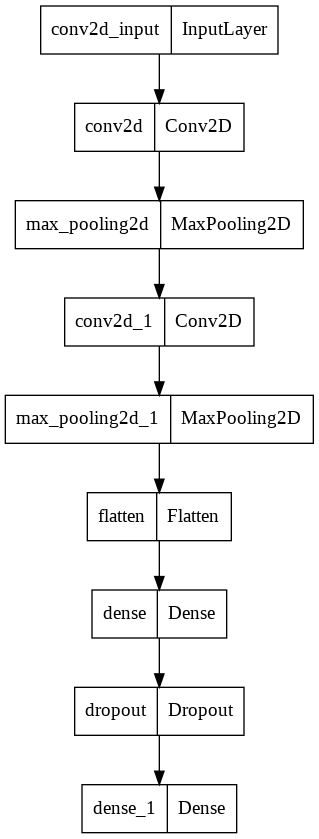

In [9]:
keras.utils.plot_model(model)

## 모형 훈련

In [11]:
# 모델 컴파일
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')

### 모델 저장
- 파이썬에서 모델을 저장한다. 그러나 자바에서는 쉽게 불러올 수 없다.
- 별도의 작업이 필요하다
  - API구성이나 Embeded 형태로 코드 구현 등

In [12]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-cnn-model.h5',
                                                save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=2,
                                                  restore_best_weights=True)
history = model.fit(train_scaled, train_target, epochs=50,
                    validation_data = (val_scaled, val_target),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/50
1500/1500 [==============================] - 16s 4ms/step - loss: 0.5517 - accuracy: 0.8022 - val_loss: 0.3416 - val_accuracy: 0.8737
Epoch 2/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3582 - accuracy: 0.8721 - val_loss: 0.2944 - val_accuracy: 0.8903
Epoch 3/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.3046 - accuracy: 0.8910 - val_loss: 0.2690 - val_accuracy: 0.8992
Epoch 4/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2718 - accuracy: 0.9020 - val_loss: 0.2430 - val_accuracy: 0.9096
Epoch 5/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2490 - accuracy: 0.9104 - val_loss: 0.2367 - val_accuracy: 0.9126
Epoch 6/50
1500/1500 [==============================] - 5s 4ms/step - loss: 0.2242 - accuracy: 0.9187 - val_loss: 0.2282 - val_accuracy: 0.9148
Epoch 7/50
1500/1500 [==============================] - 6s 4ms/step - loss: 0.2087 - accuracy: 0.9234 - val_loss: 0.2228 - val_accuracy

### 모형 평가 그래프

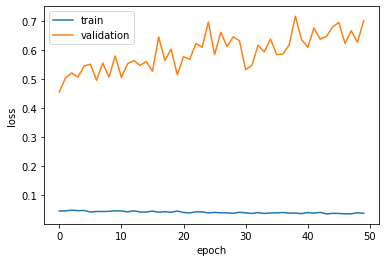

In [16]:
import matplotlib.pyplot as plt

def eval_graph(history):  
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend(['train', 'validation'])
  plt.show()

eval_graph(history)

In [17]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 2s 4ms/step - loss: 0.7003 - accuracy: 0.9231


[0.7002925872802734, 0.9230833053588867]

## 저장된 모델을 불러온다

In [18]:
model2 = keras.models.load_model('/content/best-cnn-model.h5')
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dense (Dense)               (None, 100)               3

In [21]:
model2.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 2ms/step - loss: 0.4553 - accuracy: 0.9208


[0.455348402261734, 0.9208333492279053]